In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms
from helper_methods import *
from custom_models.mlp import MLP
import seaborn as sns
import matplotlib.pyplot as plt
from custom_models.methods import fit, evaluate_network


In [3]:
# set seaborn style
sns.set_theme(context='notebook', style='whitegrid', palette='bright', color_codes=True, rc=None)

In [4]:
(
    train_loader,
    train_loader_at_eval,
    test_loader,
    validation_loader,
    n_channels,
    n_classes,
    task,
    pil_dataset,
) = get_data_loaders()

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz


In [5]:
if torch.backends.mps.is_available():
    device = torch.device("mps")
elif torch.cuda.is_available():    
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
    
print(f"Device: {device}")

Device: cuda


In [6]:
# first sample
sample = next(iter(train_loader))

print(f"Sample Shape: {sample[0].shape}")

# No of Neurons in Input Layer
# Output is flattened before feeding to MLP
input_size = n_channels * sample[0].shape[2] * sample[0].shape[3]

# No of Neurons in Hidden Layers
# hidden_sizes = [256, 128]

# No of Neurons in Output Layer
num_classes = n_classes

Sample Shape: torch.Size([128, 3, 28, 28])


ModuleList(
  (0): Linear(in_features=2352, out_features=1179, bias=True)
  (1): Linear(in_features=1179, out_features=7, bias=True)
)
Epoch [1/10], Training Loss: 2.309735649282282, Validation Loss: 1.810485601425171
Epoch [2/10], Training Loss: 1.774035185033625, Validation Loss: 1.741798996925354
Epoch [3/10], Training Loss: 1.7322083581577647, Validation Loss: 1.720325618982315
Epoch [4/10], Training Loss: 1.7073719306425614, Validation Loss: 1.698696494102478
Epoch [5/10], Training Loss: 1.7087291023947977, Validation Loss: 1.6895774006843567
Epoch [6/10], Training Loss: 1.6994110801003195, Validation Loss: 1.6977706253528595
Epoch [7/10], Training Loss: 1.6955103332346135, Validation Loss: 1.6867641806602478
Epoch [8/10], Training Loss: 1.6852166479284114, Validation Loss: 1.7319714426994324
Epoch [9/10], Training Loss: 1.7014916723424738, Validation Loss: 1.7021155655384064
Epoch [10/10], Training Loss: 1.6818707292730157, Validation Loss: 1.6760987341403961


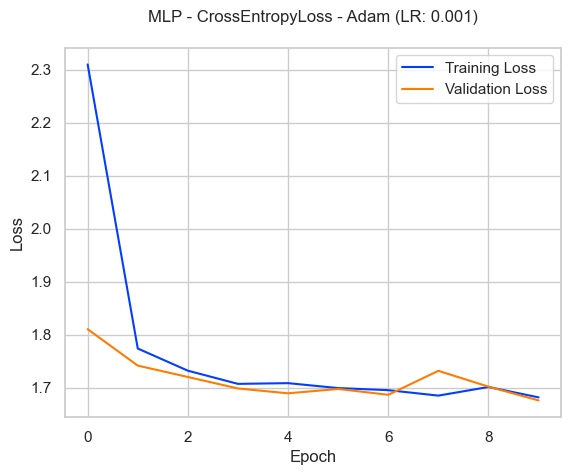

In [7]:
N_EPOCHS = 10
LR = 0.001

# Hidden Layer Definition -----------------

# Specified
# 
HIDDEN_LAYERS = (1179,)

# Or

N_LAYERS = 3
# HIDDEN_LAYERS = ((input_size + num_classes) // 2,) * n_layers
# ------------------------------------------

mlp = MLP(input_size=input_size, hidden_sizes=HIDDEN_LAYERS, num_classes=num_classes)

print(mlp.layers)

# Loss Function
# this criterion combines nn.LogSoftmax() and nn.NLLLoss() in one single class.
# It expects the target to be class indices (not one-hot encoded)
criterion = nn.CrossEntropyLoss()

# criterion = nn.MultiMarginLoss()

# Optimizer
optimizer = optim.Adam(mlp.parameters(), lr=LR)

mlp_loss_values, mlp = fit(
    training_data=train_loader,
    validation_data=validation_loader,
    nn=mlp,
    criterion=criterion,
    optimizer=optimizer,
    n_epochs=N_EPOCHS,
    to_device=True,
)

model_title = f"MLP - {criterion.__class__.__name__} - {optimizer.__class__.__name__} (LR: {LR})\n"

plot_losses(mlp_loss_values, model_title)

In [8]:
# Evaluate the model

# On Training Data
evals_training = evaluate_network(
    nn=mlp,
    test_data=train_loader_at_eval,
    to_device=True,
)

# On Test Data
evals_test = evaluate_network(
    nn=mlp,
    test_data=test_loader,
    to_device=True,
)

training_cm = evals_training.pop("cm")
test_cm = evals_test.pop("cm")


Eval on Training Data:

acc: 0.6714713857571001
f1_global: 0.6714713857571001
f1_unweighted: 0.13767274716469116
f1_weighted: 0.5574067897671227



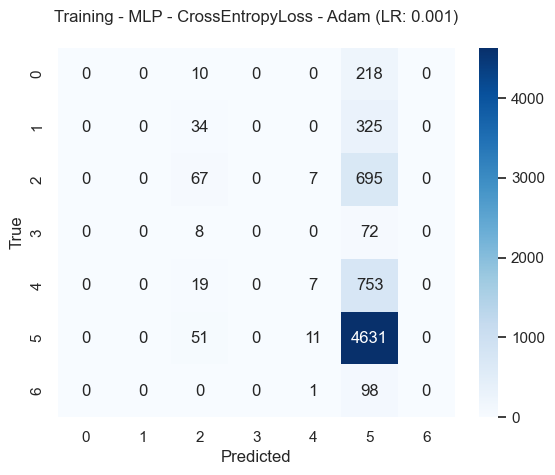

Eval on Test Data: 

acc: 0.6728179551122194
f1_global: 0.6728179551122194
f1_unweighted: 0.1447147115388725
f1_weighted: 0.5623920242239409



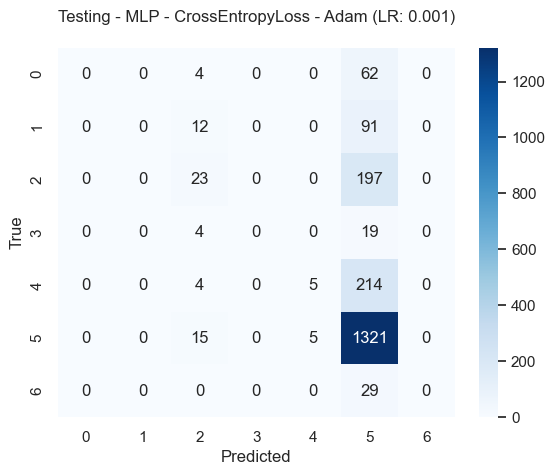

In [9]:
print(f"Eval on Training Data:\n")
print_eval(evals_training)

plot_7_class_confusion_matrix(
    training_cm,
    "Training - " + model_title,
)

print(f"Eval on Test Data: \n")
print_eval(evals_test)

plot_7_class_confusion_matrix(
    test_cm,
    "Testing - " + model_title,
)